In [1]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

import imblearn as imb
from imblearn.under_sampling import RandomUnderSampler

import scipy


In [2]:
data_dir = data_dir = '/Users/kathleenkanaley/Desktop/grapes_from_space/data/'

data_2020 = pd.read_csv(data_dir + 'img_scout_dfs/2020/smr_vis_skysat_scout_2020.csv')
data_2020 = data_2020.rename(columns={"green_red": "grvi"})


In [12]:
data_2020['GDM_sev']=0
data_2020.loc[data_2020['DM_severity'] > 10, 'GDM_sev'] =1
    
data_2020['GDM_inc']=0
data_2020.loc[data_2020['DM_inc'] > 25, 'GDM_inc'] = 1

In [13]:
data_2020.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'grvi', 'green_blue', 'row', 'panel', 'Date',
       'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'GDM_sev', 'GDM_inc'],
      dtype='object')

In [14]:
# SB + VIs 
expl_vars = ['blue', 'green', 'red', 'nir','ndvi', 'evi','msavi', 'arvi', 'grvi']
resp_var = 'GDM_inc'


# RFE example
https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [15]:
X = data_2020[expl_vars]
y = data_2020[resp_var]

rus = RandomUnderSampler(random_state=2020)
X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set
SPLIT_RND_SEED = 456
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify = y_rus)  # 70% training and 30% test

In [16]:
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)
#y_train = np.array(y_train)

2 0.864 (0.064)
3 0.898 (0.062)
4 0.880 (0.072)
5 0.886 (0.071)
6 0.890 (0.062)
7 0.883 (0.057)
8 0.885 (0.064)
9 0.879 (0.060)


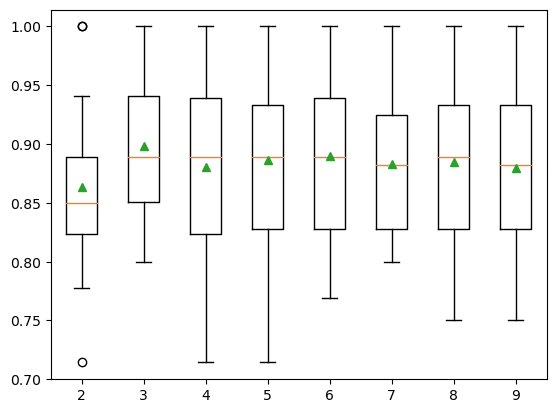

In [27]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot


# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 10):
        rfe = RFE(estimator=RandomForestClassifier(random_state= 456), n_features_to_select=i)
        model = RandomForestClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# define dataset

X = X_train_scaled
y = y_train

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [26]:
models.items()

dict_items([('2', Pipeline(steps=[('s',
                 RFE(estimator=RandomForestClassifier(random_state=456),
                     n_features_to_select=2)),
                ('m', RandomForestClassifier())])), ('3', Pipeline(steps=[('s',
                 RFE(estimator=RandomForestClassifier(random_state=456),
                     n_features_to_select=3)),
                ('m', RandomForestClassifier())])), ('4', Pipeline(steps=[('s',
                 RFE(estimator=RandomForestClassifier(random_state=456),
                     n_features_to_select=4)),
                ('m', RandomForestClassifier())])), ('5', Pipeline(steps=[('s',
                 RFE(estimator=RandomForestClassifier(random_state=456),
                     n_features_to_select=5)),
                ('m', RandomForestClassifier())])), ('6', Pipeline(steps=[('s',
                 RFE(estimator=RandomForestClassifier(random_state=456),
                     n_features_to_select=6)),
                ('m', RandomForestClassi

In [32]:
# get feature rankings for 3-feature model

# create pipeline
rfe = RFE(estimator=RandomForestClassifier(random_state= 456), n_features_to_select=3)
model = RandomForestClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# fit the model on all available data
pipeline.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print(f'Column: {expl_vars[i]}, Selected {rfe.support_[i]}, Rank: {rfe.ranking_[i]}')

Column: blue, Selected False, Rank: 6
Column: green, Selected False, Rank: 7
Column: red, Selected False, Rank: 5
Column: nir, Selected False, Rank: 4
Column: ndvi, Selected True, Rank: 1
Column: evi, Selected True, Rank: 1
Column: msavi, Selected False, Rank: 3
Column: arvi, Selected True, Rank: 1
Column: grvi, Selected False, Rank: 2


In [8]:
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier()
# rfc.fit(X_train_scaled, y_train)
# display(rfc.score(X_train_scaled, y_train))

In [9]:
# # Prediction on test data
# y_pred = rfc.predict(X_test_scaled)

In [10]:
# # Classification report
# stats = classification_report(y_test, y_pred,
#                               labels=None,
# #                               target_names=["low", "high"],
#                               sample_weight=None,
#                               digits=2,
#                               output_dict=False)
  
# print("Classification report:\n")
# print(stats)

In [11]:
# view the feature scores
# feature_scores_20 = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# feature_scores_20

# # display the predictions

# sns.set(font="Arial", font_scale=2)
# plt.rcParams['figure.figsize'] = [10, 10]

# #palette = sns.color_palette("Greens")

# order = ['blue', 'green', 'red', 'nir', 'arvi','evi', 'green_red','ndvi','msavi']
# cols = ['blue', 'green', 'red', 'orange','purple','pink', 'yellow','brown','black']
# # Creating a seaborn bar plot
# sns.barplot(x=feature_scores_20.index, y=feature_scores_20, 
#             order = ['blue', 'green', 'red', 'nir', 'arvi','evi', 'green_red','ndvi','msavi'],
#             palette=cols
#            )
# plt.title("Feature Importances\n SkySat SB +VI to classify GDM Incidence, 2020")
# plt.ylabel('Feature Importance Score')
# plt.xlabel('Features')
# plt.xticks(np.arange(len(order)), labels=['blue', 'green', 'red', 'nir', 'ARVI','EVI', 'GRVI','NDVI','MSAVI'])
# plt.ylim(0, 0.4)

# # plt.savefig("feature_imp20.svg")
# plt.show()


In [12]:
# from sklearn.model_selection import RandomizedSearchCV
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000,
# num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num =
# 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50,
# num = 10)]
# bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

In [13]:
# rs = RandomizedSearchCV(rfc,
# param_dist,
# n_iter = 100,
# cv = 3,
# verbose = 1,
# n_jobs=-1,
# random_state=0)

# rs.fit(X_train_scaled, y_train)
# rs.best_params_

In [14]:
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
# 'mean_fit_time',
# 'std_fit_time',
# 'mean_score_time',
# 'std_score_time',
# 'params',
# 'split0_test_score',
# 'split1_test_score',
# 'split2_test_score',
# 'std_test_score'],
# axis=1)

# rs_df.head(10)

In [15]:
# fig, axs = plt.subplots(ncols=3, nrows=2)
# sns.set(style="whitegrid", color_codes=True, font_scale = 2)
# fig.set_size_inches(30,25)
# sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df,
# ax=axs[0,0], color='lightgrey')
# axs[0,0].set_ylim([.0,1])
# axs[0,0].set_title(label = 'n_estimators',
# size=30, weight='bold')

# sns.barplot(x='param_min_samples_split', y='mean_test_score',
# data=rs_df, ax=axs[0,1], color='coral')
# axs[0,1].set_ylim([.0,1])
# axs[0,1].set_title(label =
# 'min_samples_split', size=30, weight='bold')

# sns.barplot(x='param_min_samples_leaf', y='mean_test_score',
# data=rs_df, ax=axs[0,2], color='lightgreen')
# axs[0,2].set_ylim([.0,1])
# axs[0,2].set_title(label =
# 'min_samples_leaf', size=30, weight='bold')

# sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df,
# ax=axs[1,0], color='wheat')
# axs[1,0].set_ylim([.0,1])
# axs[1,0].set_title(label = 'max_features',
# size=30, weight='bold')

# sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df,
# ax=axs[1,1], color='lightpink')
# axs[1,1].set_ylim([.0,1])
# axs[1,1].set_title(label = 'max_depth',
# size=30, weight='bold')

# sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df,
# ax=axs[1,2], color='skyblue')
# axs[1,2].set_ylim([.0,1])
# axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')

# plt.show()

In [16]:
# from sklearn.model_selection import GridSearchCV
# n_estimators = [100,500,700,900]
# max_features = ['sqrt']
# max_depth = [3,7,12,15]
# min_samples_split = [2,7,23]
# min_samples_leaf = [2,7]
# bootstrap = [True,False]

# param_grid = {'n_estimators': n_estimators,
# 'max_features': max_features,
# 'max_depth': max_depth,
# 'min_samples_split': min_samples_split,
# 'min_samples_leaf': min_samples_leaf,
# 'bootstrap': bootstrap}

# gs = GridSearchCV(rfc, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train_scaled, y_train)
# rfc_2 = gs.best_estimator_
# gs.best_params_

In [17]:
# y_pred = rfc.predict(X_test_scaled)

# y_pred_gs = gs.best_estimator_.predict(X_test_scaled)

In [18]:
# from sklearn.metrics import confusion_matrix

# conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred),
# index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                   
                                             

# conf_matrix_tuned = pd.DataFrame(confusion_matrix(y_test, y_pred_gs),
#         index = [np.unique(y_pred)[0],np.unique(y_pred)[1]], columns = [np.unique(y_pred)[0],np.unique(y_pred)[1]])
                                                         
# display(conf_matrix_baseline)
# display('Baseline Random Forest accuracy score', accuracy_score(y_test, y_pred))
                                                         

# display(conf_matrix_tuned)
# display('Hyperparameter Tuned Random Forest accuracy score', accuracy_score(y_test, y_pred_gs))

In [19]:
# Repeat with best performing model

In [20]:
# def run_rf(df, expl_vars, resp_var, SPLIT_RND_SEED):
#     X = df[expl_vars]
#     y = df[resp_var]
    
#     rus = RandomUnderSampler(random_state=2020)
#     X_rus, y_rus = rus.fit_resample(X, y)

# # Split dataset into training set and test set

#     X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
#                                                     test_size=0.3, 
#                                                     random_state=SPLIT_RND_SEED,
#                                                     stratify = y_rus)  # 70% training and 30% test
#     mm = MinMaxScaler()
#     X_train_scaled = mm.fit_transform(X_train)
#     X_test_scaled = mm.transform(X_test)
    
    
#     from sklearn.ensemble import RandomForestClassifier
    
#     # Modify with best parameters  
#     rf = RandomForestClassifier()
        
        
# #                                 n_estimators = 500, 
# #                                 oob_score=True, 
# #                                 #random_state=rand_state, # random number to be used, needed to reproduce the same result
# #                                 verbose=False)
    
#     rf_model = rf.fit(X_train_scaled, y_train)
    
#     y_pred = rf_model.predict(X_test_scaled)
    
#     from sklearn.metrics import accuracy_score
#     accuracy = accuracy_score(y_test, y_pred)
    
#     from sklearn.metrics import precision_recall_fscore_support
    
#     prec, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)
  
    
#     from sklearn.metrics import cohen_kappa_score
        
#     cohen_score = cohen_kappa_score(y_test, y_pred)
    
# #     from sklearn.metrics import roc_auc_score
    
# #     roc_auc_label0 = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:,0])
# #     roc_auc_label1 = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:,1])

#     label_0 = np.unique(y_pred)[0]
#     label_1 = np.unique(y_pred)[1]
    
#     metrics = {
#         'cohen_kappa': [cohen_score], 
#         'accuracy_score': [accuracy],
#         'precision {}'.format(label_0): [prec[0]],
#         'precision {}'.format(label_1): [prec[1]],
#         'recall {}'.format(label_0): [recall[0]],
#         'recall {}'.format(label_1): [recall[1]],
#         'fscore {}'.format(label_0): [fscore[0]],
#         'fscore {}'.format(label_1): [fscore[1]],

# #         'ROC-AUC {}'.format(label_0): [roc_auc_label0],
# #         'ROC-AUC {}'.format(label_1): [roc_auc_label1]
#     }
#     metrics_df = pd.DataFrame(data=metrics)
    
#     return metrics_df


In [21]:
# run_rf(data_2020, expl_vars, resp_var, 456)

In [22]:
# import random
 
# rand_list=[]
# n=100
# for i in range(n):
#     rand_list.append(random.randint(100,999))

In [23]:
# # RF model, GDM Inc 2020 SB + VI
# expl_vars = ['blue', 'green', 'red', 'nir','ndvi', 'evi','msavi', 'arvi', 'green_red']
# resp_var = 'GDM_inc'

# results_alldata = []
# for r in rand_list:
#     res_df = run_rf(data_2020, expl_vars, resp_var, r)
    
#     results_alldata.append(res_df)

In [24]:
# results_alldata_df = pd.concat(results_alldata)
# results_alldata_df.mean()

In [25]:
# Get permutation feature imp. scores
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

In [29]:
data_2020 = data_2020.rename(columns={"green_red": "grvi"})
data_2020.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'veg_smr',
       'savi_exp', 'savi', 'msavi', 'evi', 'arvi', 'gri', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'grvi', 'green_blue', 'row', 'panel', 'Date',
       'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'GDM_sev', 'GDM_inc'],
      dtype='object')

In [32]:
df = data_2020
expl_vars = ['blue', 'green', 'red', 'nir','ndvi', 'evi','msavi', 'arvi', 'grvi']
resp_var = 'GDM_inc'


X = df[expl_vars]
y = df[resp_var]
    
rus = RandomUnderSampler(random_state=2020)
X_rus, y_rus = rus.fit_resample(X, y)

# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus,
                                                    test_size=0.3, 
                                                    random_state=123,
                                                    stratify = y_rus)  # 70% training and 30% test
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)
    
    
from sklearn.ensemble import RandomForestClassifier
    
# Modify with best parameters  
rf = RandomForestClassifier(random_state= 456)
        
        
#                                 n_estimators = 500, 
#                                 oob_score=True, 
#                                 #random_state=rand_state, # random number to be used, needed to reproduce the same result
#                                 verbose=False)
    
rf_model = rf.fit(X_train_scaled, y_train)
    
#y_pred = rf_model.predict(X_test_scaled)

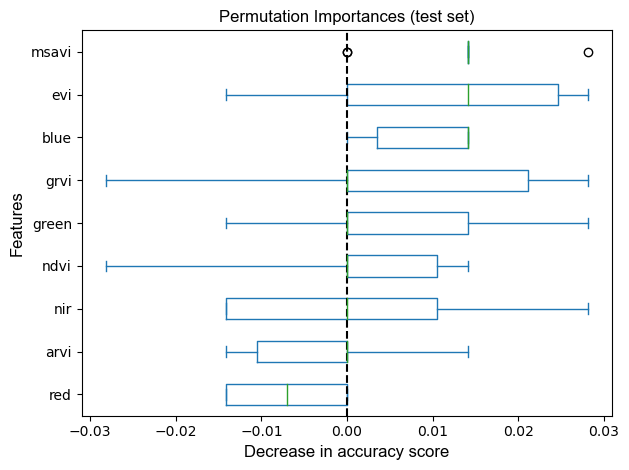

In [40]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_model, X_test_scaled, y_test, n_repeats=10, random_state=16, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)",fontname="Arial")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score",fontname="Arial", fontsize = 12)
ax.set_ylabel("Features",fontname="Arial", fontsize = 12)

ax.figure.tight_layout()